In [94]:
from typing import Dict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.datasets import MNIST 
from torchvision import transforms
from torchvision.transforms import ToTensor, Lambda
from torch.utils.data import DataLoader

import brevitas.nn as qnn

## Paths and some params

In [2]:
project_path = Path.cwd().parents[1]
mnist_path = project_path/'data/mnist'
weight_dir = project_path/'quant_he_code/weights/'

input_bit_width = 2
weight_bit_width = 4
weight_file = f"quant_fc_{input_bit_width}bits_mnist_plain_{weight_bit_width}bits_weights.pth"
weight_file_path = weight_dir / weight_file
assert weight_file_path.exists()
weight_file_path

PosixPath('/home/dk/Desktop/projects/PocketHHE/quant_he_code/weights/quant_fc_2bits_mnist_plain_4bits_weights.pth')

## Load the test dataset

In [3]:
def mnist_processing(option: int):
    if option == 0:
        transform = transforms.Compose([
            ToTensor(),
            Lambda(torch.flatten),
            lambda x: (x*4).int(),
            lambda x: x.float()/4,
        ])
    elif option == 2:
        transform = transforms.Compose([
            ToTensor(),
            Lambda(torch.flatten),
            lambda x: (x * 3).int().float(),
        ])
    else:
        raise NotImplementedError
    
    test_dataset = MNIST(root=mnist_path, train=False, transform=transform)
    
    return test_dataset

test_dataset = mnist_processing(option=input_bit_width)

im.shape = torch.Size([784])
Processed MNIST data unique values = tensor([0., 1., 2., 3.])


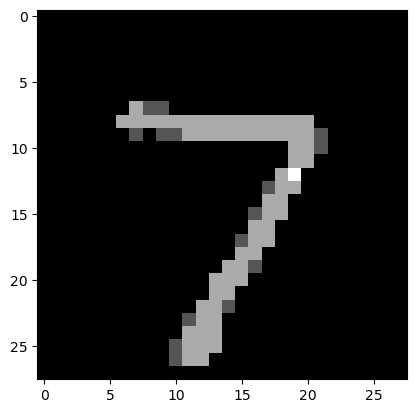

In [5]:
scale_factor_input = 1 / 3
im = test_dataset[0][0]
print(f"{im.shape = }")
print(f"Processed MNIST data unique values = {im.unique()}")
plt.imshow(im.reshape(28,28), cmap='gray')

## Define and load the network

In [85]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)  # outputs has dim [batch_size, 10]
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    """
    PytorchLightining style
    """
    def training_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch) -> Dict:
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)  # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs) -> Dict:
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result) -> None:
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch + 1, result['val_loss'], result['val_acc']))

In [80]:
class MNISTLinearQuantModel(ImageClassificationBase):
    """
    2 linear layers + 2 square activations
    """
    def __init__(self):
        super().__init__()
        self.fc1 = qnn.QuantLinear(in_features=28*28, out_features=128, bias=False, 
                                   weight_bit_width=weight_bit_width,
                                   return_quant_tensor=True)
        
        self.fc2 = qnn.QuantLinear(in_features=128, out_features=10, bias=False, 
                                   weight_bit_width=weight_bit_width, 
                                   return_quant_tensor=True)

    def forward(self, xb):      
        out = self.fc1(xb)
        out = out * out  # first square
        out = self.fc2(out)

        return out

model = MNISTLinearQuantModel()
model

MNISTLinearQuantModel(
  (fc1): QuantLinear(
    in_features=784, out_features=128, bias=False
    (input_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (output_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (weight_quant): WeightQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
      (tensor_quant): RescalingIntQuant(
        (int_quant): IntQuant(
          (float_to_int_impl): RoundSte()
          (tensor_clamp_impl): TensorClampSte()
          (delay_wrapper): DelayWrapper(
            (delay_impl): _NoDelay()
          )
        )
        (scaling_impl): StatsFromParameterScaling(
          (parameter_list_stats): _ParameterListStats(
            (first_tracked_param): _ViewParameterWrapper(
              (view_shape_impl): OverTensorView()
            )
            (stats): _Stats(
              (stats_impl): AbsMax()
            )
          )
          (stats_scaling_impl): _

In [81]:
model.load_state_dict(
    torch.load(weight_file_path, 
    map_location=torch.device('cpu'))
)

<All keys matched successfully>

## Do inference on test dataset

In [188]:
test_loader = DataLoader(test_dataset, batch_size=10000, pin_memory=True)
for x, y in test_loader:
    print(x.unique())
    print(y.unique())
    break

tensor([0., 1., 2., 3.])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


In [189]:
def evaluate(model, val_loader) -> Dict:
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

acc = evaluate(model, test_loader)['val_acc']
print(f"test accuracy with trained {weight_bit_width}-bit weights = {acc}")

test accuracy with trained 4-bit weights = 0.9776999950408936


/tmp/ipykernel_370622/2498532057.py:2: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:363.)
  _, preds = torch.max(outputs, dim=1)  # outputs has dim [batch_size, 10]


## Inspecting the model

In [14]:
model.fc1.int_weight().unique()

tensor([-7, -6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7],
       dtype=torch.int8)

In [19]:
model.fc1.quant_weight() / model.fc1.quant_weight().scale

QuantTensor(value=tensor([[0., 0., -0.,  ..., -0., 0., 0.],
        [-0., -0., -0.,  ..., -0., -0., 0.],
        [-0., 0., 0.,  ..., 0., -0., -0.],
        ...,
        [0., 0., 0.,  ..., -0., 0., -0.],
        [0., -0., -0.,  ..., 0., 0., 0.],
        [-0., 0., 0.,  ..., -0., 0., -0.]], grad_fn=<DivBackward0>), scale=None, zero_point=None, bit_width=None, signed_t=None, training_t=None)

## Manual Inference on integer data and integer weights

### Integer Data

In [191]:
x, y = next(iter(test_loader))
x = x.type(torch.int8)
print(f"input: \n--{x.dtype = }, \n--{x.shape = }, \n--{x.unique() = }")
print(f"labels: \n--{y.dtype = }, \n--{y.shape = }, \n--{y.unique() = }")

input: 
--x.dtype = torch.int8, 
--x.shape = torch.Size([10000, 784]), 
--x.unique() = tensor([0, 1, 2, 3], dtype=torch.int8)
labels: 
--y.dtype = torch.int64, 
--y.shape = torch.Size([10000]), 
--y.unique() = tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


class = 7


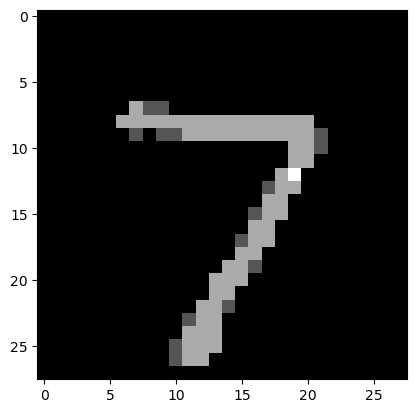

In [89]:
plt.imshow(x[0].reshape(28,28), cmap='gray')
print(f"class = {y[0]}")

### Integer Weights

Manual quantize function from Wouter's code. Needs more careful look


In [181]:
scale_factor_input = 1 / 10

def quantise(element, s, b):
    upper = 2 ** (b - 1) - 1
    lower = -2 ** (b - 1)

    value = int(round(element / s))

    if value > upper:
        return upper
    elif value < lower:
        return lower
    else:
        return value

np_quantise = np.vectorize(quantise)

float_fc1 = np.array(model.fc1.weight.data.tolist())
float_fc2 = np.array(model.fc2.weight.data.tolist())
fc1_ind_scale = model.fc1.quant_weight().scale.data.tolist()
fc2_ind_scale = model.fc2.quant_weight().scale.data.tolist()

int_fc1 = np_quantise(float_fc1, fc1_ind_scale, weight_bit_width)
int_fc2 = np_quantise(float_fc2, fc2_ind_scale, weight_bit_width)

assert torch.all(torch.tensor(int_fc2) == model.fc2.int_weight())
assert torch.all(torch.tensor(int_fc1) == model.fc1.int_weight())

In [156]:
int_fc1 = model.fc1.int_weight()
int_fc2 = model.fc2.int_weight()

In [157]:
print(f"fc1: \n--{int_fc1.dtype = }, \n--{int_fc1.shape = }, \n--{np.unique(int_fc1) = }")
print(f"fc2: \n--{int_fc2.dtype = }, \n--{int_fc2.shape = }, \n--{np.unique(int_fc2) = }")


fc1: 
--int_fc1.dtype = torch.int8, 
--int_fc1.shape = torch.Size([128, 784]), 
--np.unique(int_fc1) = array([-7, -6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7],
      dtype=int8)
fc2: 
--int_fc2.dtype = torch.int8, 
--int_fc2.shape = torch.Size([10, 128]), 
--np.unique(int_fc2) = array([-7, -6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7],
      dtype=int8)


### Manual Integer Inference

In [199]:
corrects = 0
for im, label in zip(x, y):
    out = torch.matmul(model.fc1.int_weight(), im)
    out = out.type(torch.int32)
    out = out * out
    # print(model.fc2.int_weight())
    out = torch.matmul(model.fc2.int_weight().type(torch.int32), out)
    pred = torch.argmax(out)
    if pred == label:
        corrects += 1
    # break

print(f"acc = {corrects / x.shape[0] * 100}%")

acc = 89.91%
